# Astr 257 Pluto Data Analysis, Aditya Sengupta

In [1]:
!which python

/Users/adityasengupta/opt/anaconda3/envs/astr257/bin/python


In [2]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from matplotlib import pyplot as plt
import numpy as np
from os import path
from photutils.centroids import centroid_sources, centroid_com

In [3]:
datapath = "../../../Project 1--Pluto/Data (from Arcelia)/"
getlims = ZScaleInterval().get_limits

In [4]:
def fname_to_data(fname, day=0):
    if day == 1:
        k = ""
    else:
        k = "0"
    return np.dstack([fits.open(path.join(datapath, "pluto" + str(day), fname + k + str(i+(1-day)) + ".fits"))[0].data for i in range(5)])

def view_as_ds9(img):
    vmin, vmax = getlims(img)
    plt.imshow(img, vmin=vmin, vmax=vmax)

darks, sciences, biases, flats = [fname_to_data(x).astype(np.float64) for x in ["dark", "science", "bias", "flat"]]


In [5]:
# flats are 10s but others are 30s, so correcting for that
mediandiv = lambda data: np.nanmedian(data, axis=(0,1))
flats_minus_darks = mediandiv((flats - darks / 3 - biases) * 3)# + biases + darks

corr_sciences = (sciences - darks) / flats_minus_darks
science = np.nanmedian(corr_sciences, axis=2)

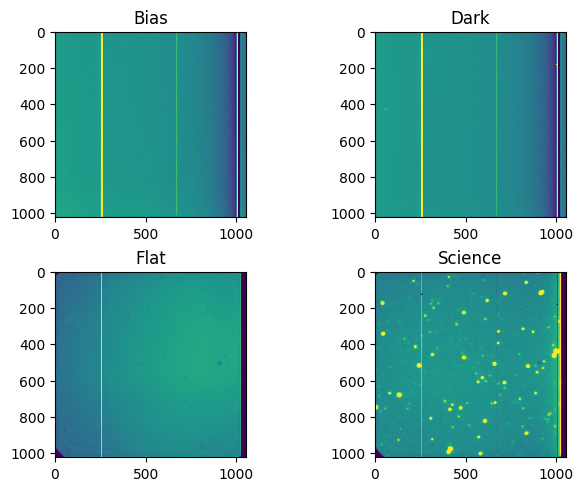

In [6]:
dark, bias, flat = (np.nanmedian(x, axis=2) for x in [darks, biases, flats])
mosaic="AB;CD"
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
for (pos, d, n) in zip(['A', 'B', 'C', 'D'], [bias, dark, flat, science], ["Bias", "Dark", "Flat", "Science"]):
    vmin, vmax = getlims(d)
    im = ax_dict[pos].imshow(d, vmin=vmin, vmax=vmax)
    ax_dict[pos].set_title(n)
    # plt.colorbar(im, ax=ax_dict[pos])


In [7]:
sciences1 = fname_to_data("science", day=1)
corr_sciences1 = (sciences1 - darks) / flats_minus_darks
science1 = np.nanmedian(corr_sciences1, axis=2)

In [8]:
fits.PrimaryHDU(science).writeto("pluto0_corr.fits", overwrite=True)
fits.PrimaryHDU(science1).writeto("pluto1_corr.fits", overwrite=True)

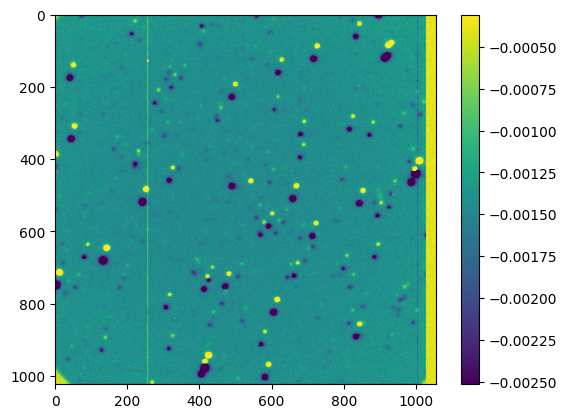

In [9]:
view_as_ds9(science1 - science)
plt.colorbar()

In [11]:
x0, y0 = np.where(science == np.nanmax(science[:200,:200])) # cutout size tuned by eye
x1, y1 = np.where(science1 == np.nanmax(science1[:200,:200]))

print(f"Approx offsets: {(x0 - x1)[0]}, {(y0 - y1)[0]}")

Approx offsets: 35, -10


In [13]:
# now use photutils to centroid both these stars
x0p, y0p = centroid_sources(science, x0, y0, centroid_func=centroid_com)
x1p, y1p = centroid_sources(science1, x1, y1, centroid_func=centroid_com)

print(f"Centroided offsets: {(x0p - x1p)[0]}, {(y0p - y1p)[0]}")

Centroided offsets: 35.04256062700844, -10.008540824738361


In [14]:
# these are close enough to integers that we can just shift by (35, -10)
w_offset = (x0 - x1)[0]
h_offset = (y0 - y1)[0]
# to do this, I'm going to embed both into a larger array and shift the night 2 ones within that
# leaving zeros at the edges in both
w, h = science.shape
science0_offset = np.zeros((w + abs(w_offset), h + abs(h_offset)))
science1_offset = np.zeros((w + abs(w_offset), h + abs(h_offset)))
science0_offset[:w,abs(h_offset):] = science
science1_offset[w_offset:,:h] = science1

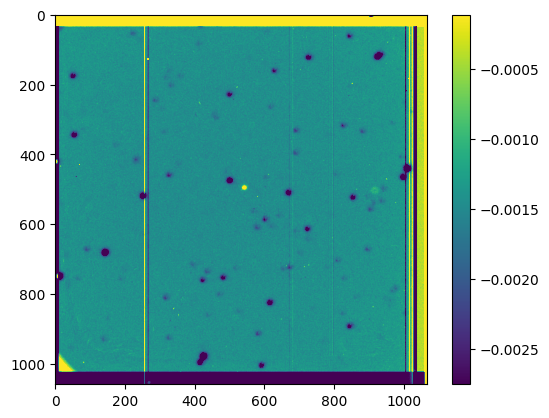

In [15]:
view_as_ds9(science1_offset - science0_offset)
plt.colorbar()

In [16]:
fits.PrimaryHDU(science0_offset).writeto("pluto0_offset.fits", overwrite=True)
fits.PrimaryHDU(science1_offset).writeto("pluto1_offset.fits", overwrite=True)
# verify: can blink between them in ds9

In [17]:
# ds9 "centroid" doesn't seem to work, so instead these are the approx x/y of Pluto on both images
# I'll use photutils to make both more precise, then convert back to arcsec
x0_pluto, y0_pluto = 542.843, 496.837
x1_pluto, y1_pluto = 500.837, 476.939
half_crop_size = 100
crop = lambda d, y, x: d[(int(x) - half_crop_size):(int(x) + half_crop_size), (int(y) - half_crop_size):(int(y) + half_crop_size)]
sci0_crop = crop(science0_offset, x0_pluto, y0_pluto)
sci1_crop = crop(science1_offset, x1_pluto, y1_pluto)

In [24]:
xf1, yf1 = centroid_sources(science0_offset, x0_pluto, y0_pluto)

In [25]:
xf2, yf2 = centroid_sources(science1_offset, x1_pluto, y1_pluto)

In [26]:
pluto_movement_px = np.sqrt((xf1 - xf2) ** 2 + (yf1 - yf2) ** 2)

array([46.53658465])

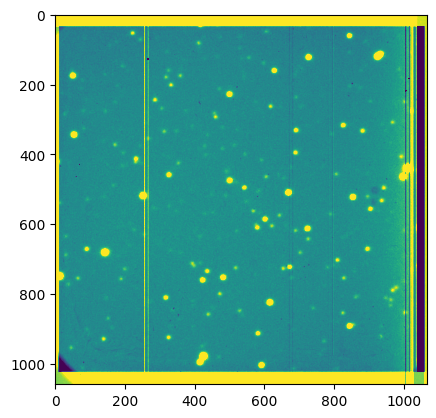

In [22]:
# to get the distance in ds9, add these together and know what you're looking at
view_as_ds9(science0_offset + science1_offset)

In [23]:
# then save this to FITS with the header of the original uncalibrated science image, so you can use the ds9 distance tool
fits.PrimaryHDU(science0_offset + science1_offset).writeto("pluto_add.fits", overwrite=True)